In [1]:
from accelerate import Accelerator
import json 
import os 
from typing import Dict, Any

config = {
        "pretrained_name": "google/vit-base-patch16-224",
        "results_path": "/scratch365/dpan/new_results/rise",
        "csv_path": "./new_results/rise",
        "max_samples": 100,
        "dataset_split": "tiny",
        "num_samples": 1000,
        "batch_size":1,
        # "auc_method": "prob", # 'acc'
        "auc_method": "acc", 
}

accelerator = Accelerator()
device = accelerator.device

print('result_path', config['results_path'])
print("csv_path", config['csv_path'])

result_path /scratch365/dpan/new_results/rise
csv_path ./new_results/rise


In [2]:
from maskgen.utils.save_utils import load_pixel_heatmap_pairs
npz_path = os.path.join(config['results_path'],'pixel_heatmap_pairs.npz')
dataloader = load_pixel_heatmap_pairs(npz_path, batch_size=1, shuffle=False)

In [3]:
from maskgen.evaluation import EvalGame
from maskgen.utils.model_utils import get_pred_model
import numpy as np
from tqdm.auto import tqdm

processor, pred_model = get_pred_model(config['pretrained_name'], device)
pred_model.eval() 
target_model = lambda x: pred_model(x).logits

auc_method = config['auc_method']
eval_game = EvalGame(target_model, auc_method=auc_method)


del_score_list = []
ins_score_list = []
mean_del_score_list = []
mean_ins_score_list = []
cum_del_score = 0
cum_ins_score = 0

# Initialize progress bar
pbar = tqdm(total=len(dataloader), desc='Evaluating')

for idx, batch in enumerate(dataloader):
    pixel_values = batch['pixel_values'].to(device)
    heatmaps = batch['heatmap'].to(device)
    del_score = eval_game.get_deletion_score(pixel_values, heatmaps)
    ins_score = eval_game.get_insertion_score(pixel_values, heatmaps)
    del_score_list.append(del_score)
    ins_score_list.append(ins_score)
    cum_del_score += del_score.item()
    mean_del_score_list.append(cum_del_score/len(del_score_list))
    mean_ins_score_list.append(cum_ins_score/len(ins_score_list))
    cum_ins_score += ins_score.item()
    
    # Update progress bar with current metrics
    current_del = cum_del_score / len(del_score_list)
    current_ins = cum_ins_score / len(ins_score_list)
    pbar.set_description(f'Del AUC: {current_del:.4f}, Ins AUC: {current_ins:.4f}')
    pbar.update(1)

pbar.close()

# accept Del AUC: 0.3161, Ins AUC: 0.7301
# reject Del AUC: 0.3385, Ins AUC: 0.6933

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
print(batch['pixel_values'].shape)
print(batch['heatmap'].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 14, 14])


In [5]:
import pandas as pd

result_dict = {'idx': range(len(del_score_list)), 
               'del_score': [x.item() for x in del_score_list], 
               'ins_score': [x.item() for x in ins_score_list],
               'mean_del_score': mean_del_score_list,
               'mean_ins_score': mean_ins_score_list}

# Save results dict to pandas dataframe and save to csv
result_df = pd.DataFrame(result_dict)
if not os.path.exists(config['csv_path']):
    os.makedirs(config['csv_path'])

csv_save_path = os.path.join(config['csv_path'], f'{auc_method}_auc_eval_results.csv')
result_df.to_csv(csv_save_path, float_format='%.4f', index=False)

ValueError: All arrays must be of the same length

# Hard cases

In [6]:
from maskgen.utils.save_utils import PixelHeatmapDataset

# # override npz_path
# npz_path = "./new_results/maskgen_unitvalue_kl1"
# npz_path = os.path.join(npz_path,'pixel_heatmap_pairs.npz')
dataset = PixelHeatmapDataset(npz_path)


Predicted class: groom, bridegroom


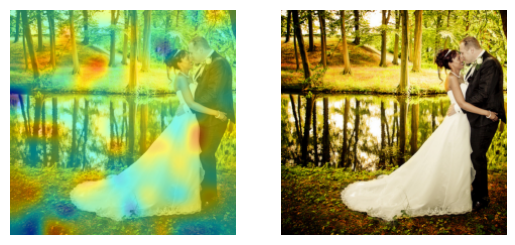

In [8]:
from maskgen.utils.img_utils import plot_overlap_np
import torch
# 55, 45, 44, 43, 40, 22, 26， 75*， 24
hard_sample = dataset[55]
image = hard_sample['pixel_values']
with torch.no_grad():
    img = image.to(device).unsqueeze(0)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()
    secondary_class_idx = pred_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", pred_model.config.id2label[label.item()])


heatmap = hard_sample['heatmap']

image = image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
heatmap = heatmap.squeeze(0).detach().cpu().numpy()

_, _ = plot_overlap_np(image, heatmap, processor.image_mean, processor.image_std)


In [22]:
print(heatmap.max(), heatmap.min()) 

0.55230737 0.43521205
